<a href="https://colab.research.google.com/github/jyotikashyap85399-tech/Image-classification/blob/main/CE_712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [2]:
!mv "kaggle (1).json" kaggle.json



In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d mdrifaturrahman33/levir-cd-change-detection



Dataset URL: https://www.kaggle.com/datasets/mdrifaturrahman33/levir-cd-change-detection
License(s): CC0-1.0
100% 3.51G/3.52G [01:46<00:00, 23.9MB/s]
100% 3.52G/3.52G [01:46<00:00, 35.3MB/s]


In [5]:
!unzip -o levir-cd-change-detection.zip -d /content/LEVIR-CD+


Archive:  levir-cd-change-detection.zip
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_638.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_639.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_640.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_641.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_642.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_643.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_644.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_645.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_646.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_647.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_648.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_649.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_650.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/train_651.png  
  inflating: /content/LEVIR-CD+/LEVIR-CD+/test/A/t

In [6]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random


In [7]:
class LevirCDPlusDataset(Dataset):
    """
    PyTorch Dataset for LEVIR-CD+ change detection.

    Returns:
        img_A:  Tensor [3, H, W]  (time T_A)
        img_B:  Tensor [3, H, W]  (time T_B)
        label:  Tensor [1, H, W]  (binary mask {0,1})
        name:   filename string (e.g., 'train_001.png')
    """
    def __init__(
        self,
        root_dir,
        split="train",          # 'train' or 'test'
        img_size=256,           # final size (H=W=256 for CDNeXt-style patches)
        random_crop=True,       # random crop in train
        augment=True            # data augmentation in train
    ):
        super().__init__()
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        self.random_crop = random_crop if split == "train" else False
        self.augment = augment if split == "train" else False

        # Folders
        self.dir_A = os.path.join(root_dir, split, "A")
        self.dir_B = os.path.join(root_dir, split, "B")
        self.dir_label = os.path.join(root_dir, split, "label")

        # All file names (use A as reference)
        self.fnames = sorted([
            f for f in os.listdir(self.dir_A)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))
        ])

        assert len(self.fnames) > 0, f"No images found in {self.dir_A}"

        # Basic transforms (ToTensor + Normalize)
        # LEVIR-CD+ is RGB with values 0–255
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],   # ImageNet stats (good with ConvNeXt)
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.fnames)

    def _load_triplet(self, index):
        name = self.fnames[index]
        path_A = os.path.join(self.dir_A, name)
        path_B = os.path.join(self.dir_B, name)
        path_L = os.path.join(self.dir_label, name)

        # Open images
        img_A = Image.open(path_A).convert("RGB")
        img_B = Image.open(path_B).convert("RGB")
        label = Image.open(path_L).convert("L")   # single-channel mask

        return img_A, img_B, label, name

    def _random_crop(self, img_A, img_B, label):
        """Apply the SAME random crop to A, B, and label."""
        w, h = img_A.size
        th, tw = self.img_size, self.img_size

        if w == tw and h == th:
            return img_A, img_B, label

        if w < tw or h < th:
            # if image is smaller, resize up first (rare for LEVIR-CD+)
            img_A = img_A.resize((tw, th), Image.BILINEAR)
            img_B = img_B.resize((tw, th), Image.BILINEAR)
            label = label.resize((tw, th), Image.NEAREST)
            return img_A, img_B, label

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)

        img_A = img_A.crop((j, i, j + tw, i + th))
        img_B = img_B.crop((j, i, j + tw, i + th))
        label = label.crop((j, i, j + tw, i + th))

        return img_A, img_B, label

    def _center_crop_or_resize(self, img_A, img_B, label):
        """For val/test: deterministic cropping / resizing."""
        # LEVIR-CD+ images are 1024x1024; we crop center 256x256 by default.
        w, h = img_A.size
        th, tw = self.img_size, self.img_size

        if w < tw or h < th:
            img_A = img_A.resize((tw, th), Image.BILINEAR)
            img_B = img_B.resize((tw, th), Image.BILINEAR)
            label = label.resize((tw, th), Image.NEAREST)
            return img_A, img_B, label

        i = (h - th) // 2
        j = (w - tw) // 2
        img_A = img_A.crop((j, i, j + tw, i + th))
        img_B = img_B.crop((j, i, j + tw, i + th))
        label = label.crop((j, i, j + tw, i + th))
        return img_A, img_B, label

    def _augment(self, img_A, img_B, label):
        """Apply SAME random geometric transforms to A, B, label."""
        # Horizontal flip
        if random.random() < 0.5:
            img_A = TF.hflip(img_A)
            img_B = TF.hflip(img_B)
            label = TF.hflip(label)

        # Vertical flip
        if random.random() < 0.5:
            img_A = TF.vflip(img_A)
            img_B = TF.vflip(img_B)
            label = TF.vflip(label)

        # 0, 90, 180, 270 degree rotation
        if random.random() < 0.5:
            k = random.choice([1, 2, 3])  # 90, 180, 270
            img_A = TF.rotate(img_A, 90 * k)
            img_B = TF.rotate(img_B, 90 * k)
            label = TF.rotate(label, 90 * k)

        # Color jitter ONLY for images (not mask)
        if random.random() < 0.8:
            color_jitter = T.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            )
            img_A = color_jitter(img_A)
            img_B = color_jitter(img_B)

        return img_A, img_B, label

    def __getitem__(self, idx):
        img_A, img_B, label, name = self._load_triplet(idx)

        # Crop
        if self.random_crop:
            img_A, img_B, label = self._random_crop(img_A, img_B, label)
        else:
            img_A, img_B, label = self._center_crop_or_resize(img_A, img_B, label)

        # Augment (train only)
        if self.augment:
            img_A, img_B, label = self._augment(img_A, img_B, label)

        # To tensor
        img_A = self.to_tensor(img_A)
        img_B = self.to_tensor(img_B)

        # Normalize with ImageNet stats (good for ConvNeXt backbone)
        img_A = self.normalize(img_A)
        img_B = self.normalize(img_B)

        # Mask: [H,W] -> [1,H,W], values {0,1}
        label = self.to_tensor(label)          # 0..1 float
        label = (label > 0.5).float()          # ensure binary

        return img_A, img_B, label, name


In [10]:
DATA_ROOT = "/content/LEVIR-CD+/LEVIR-CD+"

# Train dataset & loader
train_dataset = LevirCDPlusDataset(
    root_dir=DATA_ROOT,
    split="train",
    img_size=256,
    random_crop=True,
    augment=True,
)

test_dataset = LevirCDPlusDataset(
    root_dir=DATA_ROOT,
    split="test",
    img_size=256,
    random_crop=False,  # deterministic center crop
    augment=False
)

BATCH_SIZE = 4 # you can increase if GPU allows

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Train images:", len(train_dataset))
print("Test images :", len(test_dataset))


Train images: 637
Test images : 348


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [34]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

    def forward(self, x):           # x: [N,C,H,W]
        residual = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)   # NCHW → NHWC
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)   # NHWC → NCHW
        return x + residual


In [35]:
class TSM(nn.Module):
    """
    Simple TSM that exchanges a fraction of channels between A/B
    for each feature map. Input batch is [2B, C, H, W] = (A,B).
    """
    def __init__(self, channels, n_div=8):
        super().__init__()
        self.fold = channels // n_div

    def forward(self, x):
        # x: [2B, C, H, W]
        B2, C, H, W = x.shape
        half = B2 // 2
        xa = x[:half]      # A features [B,C,H,W]
        xb = x[half:]      # B features [B,C,H,W]

        fold = self.fold
        if fold == 0:
            return x

        out_a = xa.clone()
        out_b = xb.clone()

        # exchange middle channels
        out_a[:, fold:2*fold] = xb[:, fold:2*fold]
        out_b[:, fold:2*fold] = xa[:, fold:2*fold]

        # other channels stay the same (already in clone)
        return torch.cat([out_a, out_b], dim=0)


In [36]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        B, C, H, W = x.size()
        y = self.avg_pool(x).view(B, C)
        y = self.fc(y).view(B, C, 1, 1)
        return x * y


In [37]:
class Encoder(nn.Module):
    def __init__(self, dims=[64, 128, 256, 512]):
        super().__init__()

        # stem: /4
        self.stem_conv = nn.Conv2d(3, dims[0], kernel_size=4, stride=4, padding=0)
        self.stem_norm = nn.LayerNorm(dims[0], eps=1e-6)

        # ConvNeXt blocks per level
        self.blocks = nn.ModuleList([
            nn.Sequential(ConvNeXtBlock(dims[i]), ConvNeXtBlock(dims[i]))
            for i in range(4)
        ])

        # downsampling convs: /2 each time
        self.down = nn.ModuleList([
            nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
            for i in range(3)
        ])

    def forward(self, x):
        feats = []

        # stem
        x = self.stem_conv(x)           # [N, C0, 64, 64]
        x = x.permute(0, 2, 3, 1)       # NCHW → NHWC
        x = self.stem_norm(x)
        x = x.permute(0, 3, 1, 2)       # NHWC → NCHW

        for i in range(4):
            x = self.blocks[i](x)
            feats.append(x)             # f0..f3

            if i < 3:
                x = self.down[i](x)

        # feats: [f0 64x64, f1 32x32, f2 16x16, f3 8x8]
        return feats


In [38]:
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        # x: low-res, skip: high-res
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


In [39]:
class CDNeXt(nn.Module):
    def __init__(self, dims=[64, 128, 256, 512]):
        super().__init__()

        self.encoder = Encoder(dims)

        # TSM + Channel Attention for each level
        self.tsm = nn.ModuleList([TSM(d) for d in dims])
        self.ca  = nn.ModuleList([ChannelAttention(d) for d in dims])

        # Decoder: from deep (f3) → shallow (f0)
        self.dec3 = Decoder(dims[3] + dims[2], dims[2])  # 8→16
        self.dec2 = Decoder(dims[2] + dims[1], dims[1])  # 16→32
        self.dec1 = Decoder(dims[1] + dims[0], dims[0])  # 32→64

        # Final head: 64×64 → 256×256 → 1 channel
        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
            nn.Conv2d(dims[0], dims[0] // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(dims[0] // 2, 1, kernel_size=1)
        )

    def forward(self, A, B):
        """
        A, B: [B, 3, 256, 256]
        returns: [B, 1, 256, 256] (probabilities)
        """
        # Encode concatenated batch
        x = torch.cat([A, B], dim=0)      # [2B, 3, 256, 256]
        feats = self.encoder(x)           # list of 4 feature maps

        # Apply TSM + Channel Attention at each scale
        proc = []
        for f, tsm, ca in zip(feats, self.tsm, self.ca):
            f = tsm(f)
            f = ca(f)
            proc.append(f)

        # Split back into A/B
        B_batch = A.shape[0]
        A_feats = [f[:B_batch] for f in proc]
        B_feats = [f[B_batch:] for f in proc]

        # Difference features at each level
        diff_feats = [torch.abs(a - b) for a, b in zip(A_feats, B_feats)]
        # diff_feats[0]: 64x64, [1]: 32x32, [2]: 16x16, [3]: 8x8

        # Decode (note skip sizes carefully!)
        x = self.dec3(diff_feats[3], diff_feats[2])   # 8→16, skip 16
        x = self.dec2(x,             diff_feats[1])   # 16→32, skip 32
        x = self.dec1(x,             diff_feats[0])   # 32→64, skip 64

        # Final upsample to 256×256 and 1 channel
        x = self.final_up(x)                          # 64→256
        out = torch.sigmoid(x)
        return out


In [40]:
model = CDNeXt().cuda()

for imgA, imgB, label, _ in train_loader:
    imgA = imgA.cuda()
    imgB = imgB.cuda()
    pred = model(imgA, imgB)
    print("pred shape:", pred.shape)   # should be [B, 1, 256, 256]
    print("label shape:", label.shape) # should be [B, 1, 256, 256]
    break


pred shape: torch.Size([4, 1, 256, 256])
label shape: torch.Size([4, 1, 256, 256])


In [42]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [43]:
# ---- CONFIG ----
DATA_ROOT = "/content/LEVIR-CD+/LEVIR-CD+"  # adjust if different

IMG_SIZE    = 256
BATCH_SIZE  = 4
NUM_EPOCHS  = 50
LR          = 1e-4
VAL_SPLIT   = 0.25  # 25% of train as validation
MODEL_PATH  = "/content/cdnext_best.pth"

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [44]:
# ---- DATASETS ----
full_train_dataset = LevirCDPlusDataset(
    root_dir=DATA_ROOT,
    split="train",
    img_size=IMG_SIZE,
    random_crop=True,
    augment=True,
)

test_dataset = LevirCDPlusDataset(
    root_dir=DATA_ROOT,
    split="test",
    img_size=IMG_SIZE,
    random_crop=False,
    augment=False,
)

print("Total TRAIN images:", len(full_train_dataset))
print("Total TEST images :", len(test_dataset))

# ---- TRAIN / VAL SPLIT ----
train_len = int((1 - VAL_SPLIT) * len(full_train_dataset))
val_len   = len(full_train_dataset) - train_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


Total TRAIN images: 637
Total TEST images : 348
Train: 477, Val: 160


In [45]:
model = CDNeXt().to(device)
print("Total parameters:", sum(p.numel() for p in model.parameters())/1e6, "M")


Total parameters: 8.758081 M


In [46]:
def dice_loss(pred, target, eps=1e-6):
    """
    pred, target: [B, 1, H, W] with values in [0,1]
    """
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1) + eps

    dice = 2 * intersection / union
    return 1 - dice.mean()


In [47]:
bce = nn.BCELoss()

def criterion(pred, target):
    loss_bce  = bce(pred, target)
    loss_dice = dice_loss(pred, target)
    return loss_bce + loss_dice

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# optional scheduler (cosine)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS
)


In [48]:
def compute_metrics(pred, target, threshold=0.5, eps=1e-6):
    """
    pred, target: [B, 1, H, W] (probabilities + {0,1} labels)
    """
    pred_bin = (pred > threshold).float()

    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1 - target)).sum(dim=(1,2,3))
    fn = ((1 - pred_bin) * target).sum(dim=(1,2,3))
    tn = ((1 - pred_bin) * (1 - target)).sum(dim=(1,2,3))

    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)

    return (
        iou.mean().item(),
        f1.mean().item(),
        acc.mean().item()
    )


In [49]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    running_iou  = 0.0
    running_f1   = 0.0
    running_acc  = 0.0

    for imgA, imgB, label, _ in loader:
        imgA = imgA.to(device)
        imgB = imgB.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        pred = model(imgA, imgB)          # [B,1,H,W] probs

        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        iou, f1, acc = compute_metrics(pred.detach(), label)

        running_loss += loss.item()
        running_iou  += iou
        running_f1   += f1
        running_acc  += acc

    n = len(loader)
    return (running_loss / n,
            running_iou  / n,
            running_f1   / n,
            running_acc  / n)


In [50]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    running_iou  = 0.0
    running_f1   = 0.0
    running_acc  = 0.0

    for imgA, imgB, label, _ in loader:
        imgA = imgA.to(device)
        imgB = imgB.to(device)
        label = label.to(device)

        pred = model(imgA, imgB)
        loss = criterion(pred, label)

        iou, f1, acc = compute_metrics(pred, label)

        running_loss += loss.item()
        running_iou  += iou
        running_f1   += f1
        running_acc  += acc

    n = len(loader)
    return (running_loss / n,
            running_iou  / n,
            running_f1   / n,
            running_acc  / n)


In [51]:
best_val_iou = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_iou, train_f1, train_acc = train_one_epoch(
        model, train_loader, optimizer
    )
    val_loss, val_iou, val_f1, val_acc = evaluate(model, val_loader)

    if scheduler is not None:
        scheduler.step()

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")
    print(f"  Train: loss={train_loss:.4f}, IoU={train_iou:.4f}, F1={train_f1:.4f}, Acc={train_acc:.4f}")
    print(f"  Val  : loss={val_loss:.4f}, IoU={val_iou:.4f}, F1={val_f1:.4f}, Acc={val_acc:.4f}")

    # Save best model (by val IoU)
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✅ New best model saved (IoU={best_val_iou:.4f})")


Epoch [1/50]
  Train: loss=1.2260, IoU=0.0020, F1=0.0035, Acc=0.9463
  Val  : loss=1.2100, IoU=0.0000, F1=0.0000, Acc=0.9526
Epoch [2/50]
  Train: loss=1.1403, IoU=0.0000, F1=0.0000, Acc=0.9542
  Val  : loss=1.1301, IoU=0.0000, F1=0.0000, Acc=0.9494
Epoch [3/50]
  Train: loss=1.1286, IoU=0.0000, F1=0.0000, Acc=0.9563
  Val  : loss=1.1452, IoU=0.0000, F1=0.0000, Acc=0.9455
Epoch [4/50]
  Train: loss=1.1134, IoU=0.0000, F1=0.0000, Acc=0.9543
  Val  : loss=1.0853, IoU=0.0000, F1=0.0000, Acc=0.9495
Epoch [5/50]
  Train: loss=1.1124, IoU=0.0000, F1=0.0000, Acc=0.9482
  Val  : loss=1.0668, IoU=0.0000, F1=0.0000, Acc=0.9428
Epoch [6/50]
  Train: loss=1.0620, IoU=0.0000, F1=0.0000, Acc=0.9549
  Val  : loss=1.0372, IoU=0.0000, F1=0.0000, Acc=0.9564
Epoch [7/50]
  Train: loss=1.0436, IoU=0.0000, F1=0.0000, Acc=0.9556
  Val  : loss=1.0394, IoU=0.0000, F1=0.0000, Acc=0.9528
Epoch [8/50]
  Train: loss=1.0315, IoU=0.0000, F1=0.0000, Acc=0.9573
  Val  : loss=1.0219, IoU=0.0000, F1=0.0000, Acc=0.9467


In [52]:
# Load best model
best_model = CDNeXt().to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

test_loss, test_iou, test_f1, test_acc = evaluate(best_model, test_loader)
print("=== TEST RESULTS ===")
print(f"Loss: {test_loss:.4f}")
print(f"IoU : {test_iou:.4f}")
print(f"F1  : {test_f1:.4f}")
print(f"Acc : {test_acc:.4f}")


=== TEST RESULTS ===
Loss: 0.9434
IoU : 0.1404
F1  : 0.1844
Acc : 0.9553


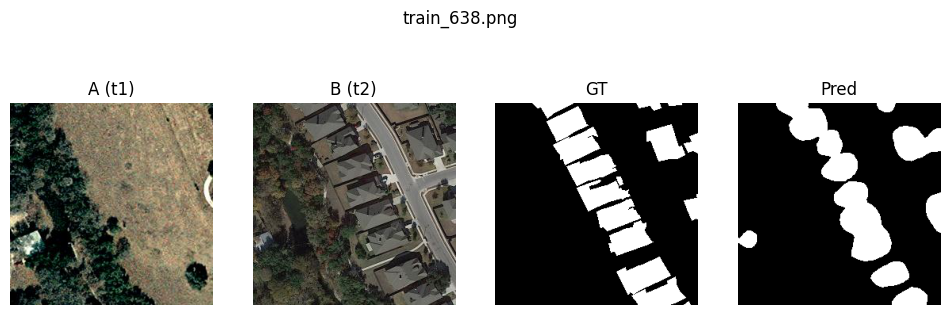

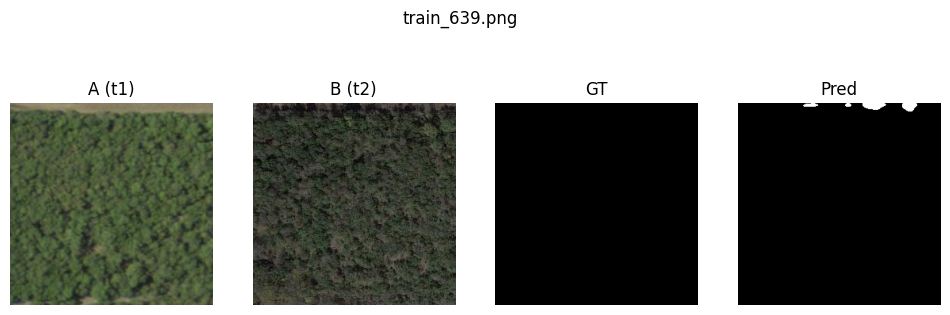

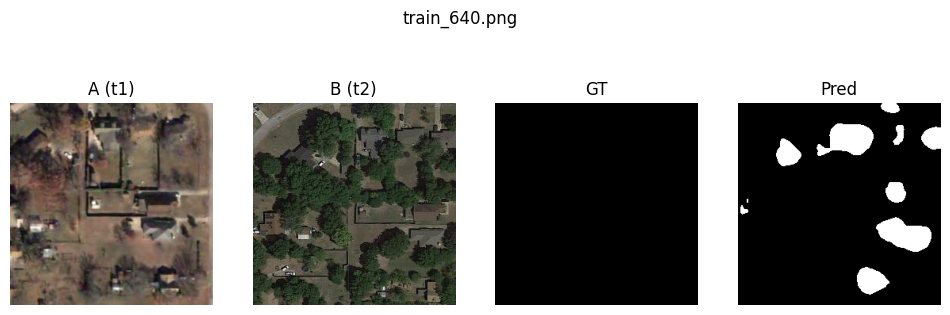

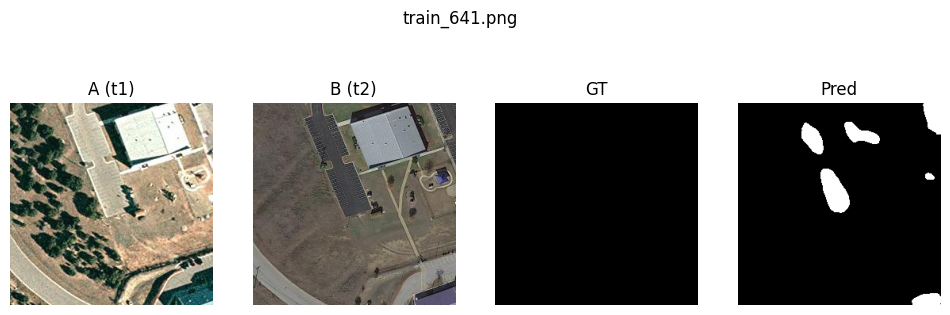

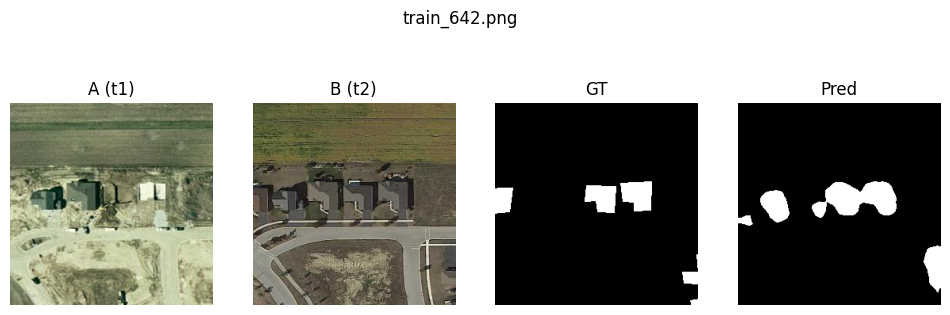

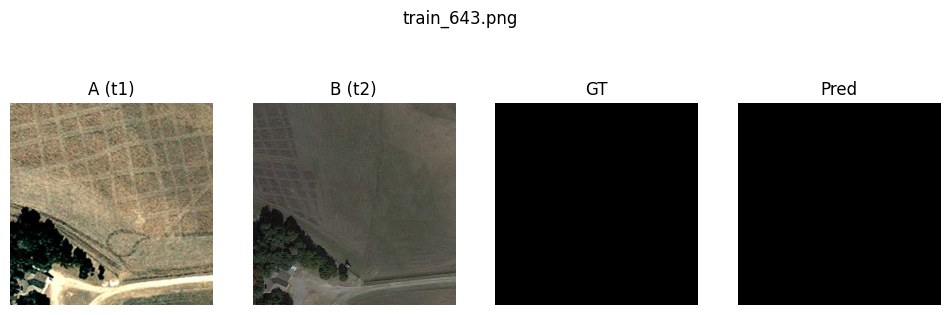

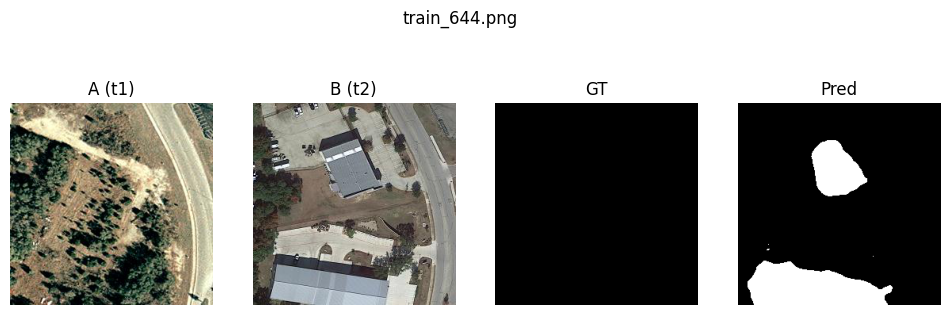

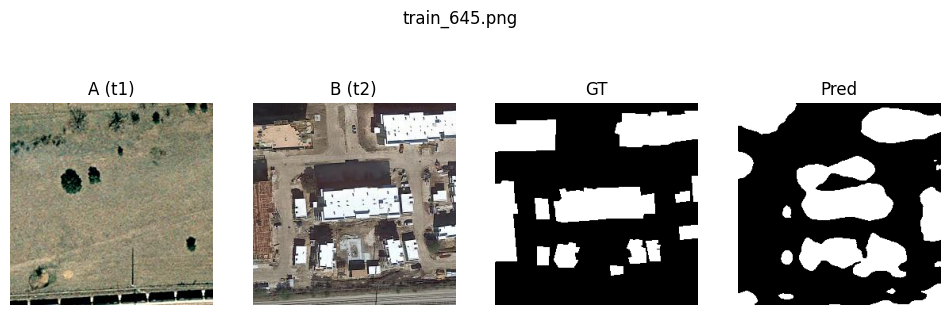

In [53]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_samples(model, loader, num_batches=2):
    model.eval()
    batch_count = 0

    for imgA, imgB, label, names in loader:
        imgA = imgA.to(device)
        imgB = imgB.to(device)
        label = label.to(device)

        pred = model(imgA, imgB)
        pred_bin = (pred > 0.5).float()

        for i in range(imgA.size(0)):
            fig, axes = plt.subplots(1, 4, figsize=(12, 4))

            # denormalize A/B just for visualization (approx)
            def denorm(x):
                mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(3,1,1)
                std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(3,1,1)
                x = x * std + mean
                return x.clamp(0,1)

            a_show = denorm(imgA[i]).permute(1,2,0).cpu().numpy()
            b_show = denorm(imgB[i]).permute(1,2,0).cpu().numpy()
            gt     = label[i,0].cpu().numpy()
            pr     = pred_bin[i,0].cpu().numpy()

            axes[0].imshow(a_show); axes[0].set_title("A (t1)"); axes[0].axis("off")
            axes[1].imshow(b_show); axes[1].set_title("B (t2)"); axes[1].axis("off")
            axes[2].imshow(gt, cmap="gray"); axes[2].set_title("GT"); axes[2].axis("off")
            axes[3].imshow(pr, cmap="gray"); axes[3].set_title("Pred"); axes[3].axis("off")

            fig.suptitle(names[i])
            plt.show()

        batch_count += 1
        if batch_count >= num_batches:
            break

visualize_samples(best_model, test_loader, num_batches=2)
